In [1]:
import os
import math
import warnings
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor
import torch.distributions as td

from torchdiffeq import odeint
from torchsde import sdeint
from torchtyping import TensorType

from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from typing import List,Any, Callable, Tuple, Union


os.chdir("/home/s2113174/Projects-1")
warnings.simplefilter(action='ignore', category=(np.VisibleDeprecationWarning))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def generate_CIR(N=10_000, a=1, b=1.2, sigma=0.2, regular=True):
    class CIR(nn.Module):
        """ Cox-Ingersoll-Ross """
        noise_type = 'diagonal'
        sde_type = 'ito'

        def __init__(self, a, b, sigma):
            super().__init__()
            self.a = a
            self.b = b
            self.sigma = sigma

        def f(self, t, y):
            return self.a * (self.b - y)

        def g(self, t, y):
            return self.sigma * y.sqrt()

    f = CIR(a, b, sigma)
    if regular:
        t = torch.linspace(0, 63, 64)
        x0 = torch.randn(N, 1).abs()

        with torch.no_grad():
            x = sdeint(f, x0, t, dt=0.1).transpose(0, 1)

        t = t.view(1, -1, 1).expand_as(x[...,:1])
    
    np.savez('../Projects-1/Difussion Models/TimeSeries/Data/cir.npz', t=t.numpy(), x=x.numpy())
    return x,t


    #     np.savez(DATA_DIR / 'cir.npz', t=t.numpy(), x=x.numpy())
    # else:
    #     np.savez(DATA_DIR / 'cir_irregular.npz', t=t.numpy(), x=x.numpy())

def generate_lorenz(N=10_000, rho=28, sigma=10, beta=2.667, regular=True):
    class Lorenz(nn.Module):
        def __init__(self, rho, sigma, beta):
            super().__init__()
            self.rho = rho
            self.sigma = sigma
            self.beta = beta

        def forward(self, t, inp):
            x, y, z = inp.chunk(3, dim=-1)
            dx = self.sigma * (y - x)
            dy = x * self.rho - y - x * z
            dz = x * y - self.beta * z
            d_inp = torch.cat([dx, dy, dz], -1)
            return d_inp

    f = Lorenz(rho, sigma, beta)
    if regular:
        t = torch.linspace(0, 2, 100)
        x0 = torch.randn(N, 3) * 10

        with torch.no_grad():
            x = odeint(f, x0, t, method='dopri5').transpose(0, 1)
        t = t.view(1, -1, 1).expand_as(x[...,:1])

    np.savez('../Projects-1/Difussion Models/TimeSeries/Data/lorenz.npz', t=t.numpy(), x=x.numpy())
    
    return x,t

        
    # else:
    #     np.savez(DATA_DIR / 'lorenz_irregular.npz', t=t.numpy(), x=x.numpy())

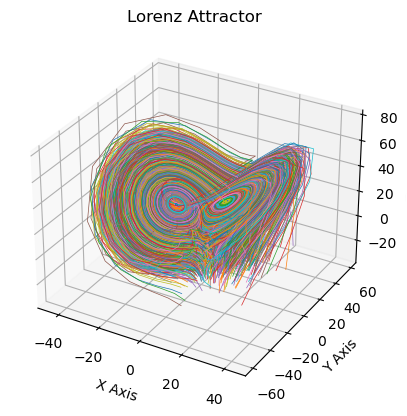

In [3]:
x,t = generate_CIR()
x,t = generate_lorenz()

ax = plt.figure().add_subplot(projection='3d')

for i in range(10_000):
    ax.plot(x[i,:,0].numpy(),x[i,:,1].numpy(),x[i,:,2].numpy(), lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")

plt.show()

In [4]:
x.shape

torch.Size([10000, 100, 3])

In [4]:
class FeedForward(nn.Module):
    def __init__(self, in_dim: int, hidden_dims: List[int], out_dim: int, activation: Callable = nn.ReLU(), final_activation: Callable = None):
        super().__init__()

        hidden_dims = hidden_dims[:]
        hidden_dims.append(out_dim)

        layers = [nn.Linear(in_dim, hidden_dims[0])]

        for i in range(len(hidden_dims) - 1):
            layers.append(activation)
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))

        if final_activation is not None:
            layers.append(final_activation)

        self.net = nn.Sequential(*layers)

    def forward(self, x: TensorType[..., 'in_dim']) -> TensorType[..., 'out_dim']:
        return self.net(x)

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim: int, max_value: float):
        super().__init__()
        self.max_value = max_value

        linear_dim = dim // 2
        periodic_dim = dim - linear_dim

        self.scale = torch.exp(-2 * torch.arange(0, periodic_dim).float() * math.log(self.max_value) / periodic_dim)
        self.shift = torch.zeros(periodic_dim)
        self.shift[::2] = 0.5 * math.pi

        self.linear_proj = nn.Linear(1, linear_dim)

    def forward(self, t: TensorType[..., 'length', 1]) -> TensorType[..., 'length', 'dim']:
        periodic = torch.sin(t * self.scale.to(t) + self.shift.to(t))
        linear = self.linear_proj(t / self.max_value)

        return torch.cat([linear, periodic], -1)

In [6]:
class FeedForwardModel(nn.Module):
    def __init__(self, dim, hidden_dim, max_i, num_layers=3, **kwargs):
        super().__init__()
        self.t_enc = PositionalEncoding(hidden_dim, max_value=1)
        self.i_enc = PositionalEncoding(hidden_dim, max_value=max_i)
        self.input_proj = nn.Linear(dim, hidden_dim)
        self.net = FeedForward(3 * hidden_dim, [hidden_dim] * num_layers, dim)

    def forward(self, x, *, t, i, **kwargs):
        t = self.t_enc(t)
        i = self.i_enc(i)
        x = self.input_proj(x)
        x = torch.cat([x, t, i], -1)
        return self.net(x)

class RNNModel(nn.Module):
    def __init__(self, dim, hidden_dim, max_i, num_layers=2, bidirectional=True, **kwargs):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.directions = 2 if bidirectional else 1

        self.t_enc = PositionalEncoding(hidden_dim, max_value=1)
        self.i_enc = PositionalEncoding(hidden_dim, max_value=max_i)
        self.init_proj = FeedForward(hidden_dim, [], self.num_layers * self.directions * hidden_dim)
        self.input_proj = FeedForward(dim, [], hidden_dim)
        self.rnn = nn.GRU(3 * hidden_dim,hidden_dim,num_layers=num_layers,bidirectional=bidirectional, batch_first=True,)
        self.output_proj = FeedForward(self.directions * hidden_dim, [], dim)

    def forward(self,x: TensorType['B', 'L', 'D'],*,t: TensorType['B', 'L', 1],i: TensorType['B', 'L', 1], **kwargs) -> TensorType['B', 'L', 'D']:
        shape = x.shape

        t = self.t_enc(t.view(-1, shape[-2], 1))
        i = self.i_enc(i.view(-1, shape[-2], 1))
        x = self.input_proj(x.view(-1, *shape[-2:]))

        init = self.init_proj(i[:,0])
        init = init.view(self.num_layers * self.directions, -1, self.hidden_dim)

        x = torch.cat([x, t, i], -1)

        y, _ = self.rnn(x, init)
        y = self.output_proj(y)
        y = y.view(*shape)

        return y

In [7]:
class TransformerModel(nn.Module):
    def __init__(self, dim, hidden_dim, max_i, num_layers=8,
                 num_ref_points=10, **kwargs):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.t_enc = PositionalEncoding(hidden_dim, max_value=1)
        self.i_enc = PositionalEncoding(hidden_dim, max_value=max_i)

        self.input_proj = FeedForward(dim, [], hidden_dim)

        self.proj = FeedForward(3 * hidden_dim, [], hidden_dim, final_activation=nn.ReLU())

        self.enc_att = []
        self.i_proj = []
        for _ in range(num_layers):
            self.enc_att.append(nn.MultiheadAttention(hidden_dim, num_heads=1, batch_first=True))
            self.i_proj.append(nn.Linear(3 * hidden_dim, hidden_dim))
        self.enc_att = nn.ModuleList(self.enc_att)
        self.i_proj = nn.ModuleList(self.i_proj)

        self.output_proj = FeedForward(hidden_dim, [], dim)

    def forward(
        self,
        x: TensorType['B', 'L', 'D'],
        *,
        t: TensorType['B', 'L', 1],
        i: TensorType['B', 'L', 1],
        **kwargs,
    ) -> TensorType['B', 'L', 'D']:
        shape = x.shape

        x = x.view(-1, *shape[-2:])
        t = t.view(-1, shape[-2], 1)
        i = i.view(-1, shape[-2], 1)

        x = self.input_proj(x)
        t = self.t_enc(t)
        i = self.i_enc(i)

        x = self.proj(torch.cat([x, t, i], -1))

        for att_layer, i_proj in zip(self.enc_att, self.i_proj):
            y, _ = att_layer(
                query=x,
                key=x,
                value=x,
            )
            x = x + torch.relu(y)

        x = self.output_proj(x)
        x = x.view(*shape)
        return x

In [8]:
def get_beta_scheduler(name: str) -> Callable:
    if name == 'linear':
        return BetaLinear

def get_loss_weighting(name: str) -> Callable:
    if name == 'exponential':
        return exponential_loss_weighting

class BetaLinear(nn.Module):
    """
    Linear scheduling for beta.
    Input t is always from interval [0, 1].

    Args:
        start: Lower bound (float)
        end: Upper bound (float)
    """
    def __init__(self, start: float, end: float):
        super().__init__()
        self.start = start
        self.end = end

    def forward(self, t: Tensor) -> Tensor:
        return self.start * (1 - t) + self.end * t

    def integral(self, t: Tensor) -> Tensor:
        return 0.5 * (self.end - self.start) * t.square() + self.start * t


def exponential_loss_weighting(beta_fn, i):
    return 1 - torch.exp(-beta_fn.integral(i))

In [9]:
class Normal(nn.Module):
    def __init__(self, dim: int, **kwargs):
        super().__init__()
        self.dim = dim

    def forward(self, *shape, **kwargs):
        return torch.randn(*shape, self.dim)

    def covariance(self, **kwargs):
        return torch.eye(self.dim)


class Wiener(nn.Module):
    """
    Wiener process / Brownian motion.
    """
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(
        self,
        t: Union[TensorType['seq_len'], TensorType[..., 'seq_len', 1]],
        **kwargs,
    ) -> Union[TensorType['seq_len'], TensorType[..., 'seq_len', 'dim']]:
        one_dimensional = len(t.shape) == 1

        if one_dimensional:
            t = t.unsqueeze(-1)
        t = t.repeat_interleave(self.dim, dim=-1)

        dt = torch.diff(t, dim=-2, prepend=torch.zeros_like(t[...,:1,:]).to(t))
        dw = torch.randn_like(dt) * dt.clamp(1e-5).sqrt()
        w = dw.cumsum(dim=-2)

        if one_dimensional and self.dim == 1:
            w = w.squeeze(-1)
        return w


class OrnsteinUhlenbeck(nn.Module):
    """
    Ornstein-Uhlenbeck process.

    Args:
        theta: Diffusion param, higher value = spikier (float)
    """
    def __init__(self, dim: int, theta: float = 0.5):
        super().__init__()
        self.dim = dim
        self.theta = theta
        self.wiener = Wiener(dim)

    def forward(
        self,
        *args,
        t: TensorType[..., 'seq_len', 1],
        **kwargs,
    ) -> TensorType[..., 'seq_len', 'dim']:

        delta = torch.diff(t, dim=-2, prepend=torch.zeros_like(t[...,:1,:]))
        coeff = torch.exp(-self.theta * delta)

        sample = []

        x = torch.randn(*t.shape[:-2], 1, self.dim).to(t)
        for i in range(coeff.shape[-2]):
            z = torch.randn(*t.shape[:-2], 1, self.dim).to(t)
            c = coeff[...,i,None,:]
            x = c * x + torch.sqrt(1 - c**2) * z
            sample.append(x)

        sample = torch.cat(sample, dim=-2)
        return sample

    def covariance(
        self,
        t: TensorType[..., 'seq_len', 1],
        diag_epsilon: float = 1e-4,
        **kwargs,
    ) -> TensorType[..., 'seq_len', 'seq_len']:
        t = t.squeeze(-1)
        diag = torch.eye(t.shape[-1]).to(t) * diag_epsilon
        cov = torch.exp(-(t.unsqueeze(-1) - t.unsqueeze(-2)).abs() * self.theta)
        return cov + diag

    def covariance_cholesky(self, t: TensorType[..., 'seq_len', 1]) -> TensorType[..., 'seq_len', 'seq_len']:
        return torch.linalg.cholesky(self.covariance(t))

    def covariance_inverse(self, t: TensorType[..., 'seq_len', 1]) -> TensorType[..., 'seq_len', 'seq_len']:
        return torch.linalg.inv(self.covariance(t))


class GaussianProcess(nn.Module):
    """
    Gaussian random field for one-dimensional (temporal) data.
    """
    def __init__(self, dim: int, sigma: float = 0.1):
        super().__init__()
        self.dim = dim
        self.sigma = sigma

    def forward(
        self,
        *args,
        t: TensorType[..., 'N', 1],
        **kwargs,
    ) -> TensorType[..., 'N', 'dim']:
        # If N is very large this could become slow
        # In that case, consider using sparse GP
        L = self.covariance_cholesky(t)
        e = torch.randn(*t.shape[:-1], self.dim).to(t)
        return L @ e

    def covariance(
        self,
        t: TensorType[..., 'N', 1],
        diag_epsilon: float = 1e-4,
        **kwargs,
    ) -> TensorType[..., 'N', 'N']:
        if t.shape[-1] != 1 or len(t.shape) < 2:
            t = t.unsqueeze(-1)
        distance = t - t.transpose(-1, -2)
        diag = torch.eye(t.shape[-2]).to(t) * diag_epsilon
        return torch.exp(-torch.square(distance / self.sigma)) + diag

    def covariance_cholesky(self, t: TensorType[..., 'N', 1]) -> TensorType[..., 'N', 'N']:
        return torch.linalg.cholesky(self.covariance(t))

    def covariance_inverse(self, t: TensorType[..., 'N', 1]) -> TensorType[..., 'N', 'N']:
        return torch.linalg.inv(self.covariance(t))

In [10]:
class DiscreteDiffusion(nn.Module):
    """
    Discrete diffusion (https://arxiv.org/abs/2006.11239)

    Args:
        dim: Dimension of data
        num_steps: Number of diffusion steps
        beta_fn: Scheduler for noise levels
        noise_fn: Type of noise
        parallel_elbo: Whether to compute ELBO in parallel or not
    """
    def __init__(
        self,
        dim: int,
        num_steps: int,
        beta_fn: Callable,
        noise_fn: Callable,
        parallel_elbo: bool = False,
        is_time_series: bool = False,
        predict_gaussian_noise: bool = True,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.num_steps = num_steps
        self.parallel_elbo = parallel_elbo
        self.is_time_series = is_time_series
        self.predict_gaussian_noise = predict_gaussian_noise

        self.betas = beta_fn(torch.linspace(0, 1, num_steps))
        self.alphas = torch.cumprod(1 - self.betas, dim=0)

        self.noise = noise_fn

    def forward(
        self,
        x: TensorType[..., 'dim'],
        i: TensorType[..., 1],
        **kwargs,
    ) -> Tuple[TensorType[..., 'dim'], TensorType[..., 'dim']]:

        noise_gaussian = torch.randn_like(x)

        if self.is_time_series:
            cov = self.noise.covariance(**kwargs)
            L = torch.linalg.cholesky(cov)
            noise = L @ noise_gaussian
        else:
            noise = noise_gaussian

        alpha = self.alphas[i.long()].to(x)
        y = torch.sqrt(alpha) * x + torch.sqrt(1 - alpha) * noise

        if self.predict_gaussian_noise:
            return y, noise_gaussian
        else:
            return y, noise

    def get_loss(
        self,
        model: Callable,
        x: TensorType[..., 'dim'],
        **kwargs,
    ) -> TensorType[..., 'dim']:

        i = torch.randint(0, self.num_steps, size=(x.shape[0],))
        i = i.view(-1, *(1,) * len(x.shape[1:])).expand_as(x[...,:1]).to(x)

        x_noisy, noise = self.forward(x, i, **kwargs)

        pred_noise = model(x_noisy, i=i, **kwargs)
        loss = (pred_noise - noise)**2

        return loss

    @torch.no_grad()
    def sample(
        self,
        model: Callable,
        num_samples: Union[int, Tuple],
        device: str = 'cpu',
        **kwargs,
    ) -> TensorType['*num_samples', 'dim']:
        if isinstance(num_samples, int):
            num_samples = (num_samples,)

        x = self.noise(*num_samples, **kwargs).to(device)

        if self.is_time_series and self.predict_gaussian_noise:
            cov = self.noise.covariance(**kwargs)
            L = torch.linalg.cholesky(cov)
        else:
            L = None

        for diff_step in reversed(range(0, self.num_steps)):
            alpha = self.alphas[diff_step]
            beta = self.betas[diff_step]

            # An alternative can be:
            # alpha_prev = self.alphas[diff_step - 1]
            # sigma = beta * (1 - alpha_prev) / (1 - alpha)
            sigma = beta

            if diff_step == 0:
                z = 0
            else:
                z = self.noise(*num_samples, **kwargs).to(device)

            i = torch.Tensor([diff_step]).expand_as(x[...,:1]).to(device)
            pred_noise = model(x, i=i, **kwargs)

            if L is not None:
                pred_noise = L @ pred_noise

            x = (x - beta * pred_noise / (1 - alpha).sqrt()) / (1 - beta).sqrt() + sigma.sqrt() * z

        return x

    @torch.no_grad()
    def log_prob(
        self,
        model: Callable,
        x: TensorType[..., 'dim'],
        num_samples: int = 1,
        **kwargs,
    ) -> TensorType[..., 1]:
        if self.is_time_series and self.predict_gaussian_noise:
            cov = self.noise.covariance(**kwargs)
            L = torch.linalg.cholesky(cov)
        else:
            L = None

        func = self._elbo_parallel if self.parallel_elbo else self._elbo_sequential
        return func(model, x, num_samples=num_samples, L=L, **kwargs)

    def _elbo_parallel(
        self,
        model: Callable,
        x: TensorType[..., 'dim'],
        L: TensorType[..., 'seq_len', 'seq_len'],
        num_samples: int = 1,
        **kwargs,
    ) -> TensorType[..., 1]:
        """
        Computes ELBO over all diffusion steps in parallel,
        then averages over `num_samples` runs.
        If diffusion `num_steps` large (and `num_samples` small)
        it will be heavy on the GPU memory.

        Args:
            model: Denoising diffusion model
            x: Clean input data
            num_samples: How many times to compute ELBO, final
                result is averaged over all ELBO samples
            **kwargs: Can be time, latent etc. depending on a model
        """
        elbo = 0

        i = expand_to_x(torch.arange(self.num_steps), x).expand(-1, *x[...,:1].shape).contiguous()
        alphas = expand_to_x(self.alphas, x)
        betas = expand_to_x(self.betas, x)

        xt, kwargs = expand_x_and_kwargs(x, kwargs, self.num_steps)

        for _ in range(num_samples):
            # Get diffused outputs
            xt, _ = self.forward(x, i, **kwargs) # [num_steps, ..., dim]

            # Output predicted noise
            epsilon = model(xt, i=i, **kwargs)

            if L is not None:
                epsilon = L @ epsilon

            # p(x_{t-1} | p_t)
            p_mu = get_p_mu(xt, betas, alphas, epsilon)
            px = td.Independent(td.Normal(p_mu[1:], betas[1:].sqrt()), 1)

            # p(x_0 | x_1)
            log_prob_x0_x1 = td.Independent(td.Normal(p_mu[0], betas[0].sqrt()), 1).log_prob(x)
            assert log_prob_x0_x1.shape == x.shape[:-1]

            # q(x_{t-1} | x_0, x_t), t > 1
            qx = get_qx(x.unsqueeze(0), xt[1:], alphas[1:], alphas[:-1], betas[1:])

            # KL[q(x_{t-1} | p_t) || p(x_{t-1} | p_t)]
            kl_q_p = td.kl_divergence(qx, px).sum(0)
            assert kl_q_p.shape == x.shape[:-1]

            # ELBO
            elbo_contribution = (log_prob_x0_x1 - kl_q_p) / num_samples
            elbo += elbo_contribution

        elbo = reduce_elbo(elbo, x)
        return elbo

    def _elbo_sequential(
        self,
        model: Callable,
        x: TensorType[..., 'dim'],
        L: TensorType[..., 'seq_len', 'seq_len'],
        num_samples: int = 1,
        **kwargs,
    ) -> TensorType[..., 1]:
        """
        Computes ELBO as a sum of diffusion steps - sequentially.

        Args:
            model: Denoising diffusion model
            x: Clean input data
            num_samples: How many times to compute ELBO, final
                result is averaged over all ELBO samples
            **kwargs: Can be time, latent etc. depending on a model
        """
        elbo = 0

        x, kwargs = expand_x_and_kwargs(x, kwargs, num_samples)

        for i in range(self.num_steps):
            # Prepare variables
            beta = self.betas[i].to(x)
            alpha = self.alphas[i].to(x)
            step = torch.Tensor([i]).expand_as(x[...,:1]).to(x)

            # Diffuse and predict noise
            xt, _ = self.forward(x, i=step, **kwargs)
            epsilon = model(xt, i=step, **kwargs)

            if L is not None:
                epsilon = L @ epsilon

            assert xt.shape == x.shape == epsilon.shape

            # p(x_{t-1} | p_t)
            p_mu = get_p_mu(xt, beta, alpha, epsilon)
            px = td.Independent(td.Normal(p_mu, beta.sqrt()), 1)

            if i == 0:
                elbo = elbo + px.log_prob(x).mean(0)
            else:
                prev_alpha = self.alphas[i - 1]

                # q(x_{t-1} | x_0, x_t), t > 1
                qx = get_qx(x, xt, alpha, prev_alpha, beta)

                # KL[q(x_{t-1} | p_t) || p(x_{t-1} | p_t)]
                kl = td.kl_divergence(qx, px).mean(0)
                elbo = elbo - kl

        elbo = reduce_elbo(elbo, x)
        return elbo


class GaussianDiffusion(DiscreteDiffusion):
    """ Discrete diffusion with Gaussian noise """
    def __init__(self, dim: int, num_steps: int, beta_fn: Callable, **kwargs):
        super().__init__(dim, num_steps, beta_fn, noise_fn=Normal(dim), **kwargs)


class OUDiffusion(DiscreteDiffusion):
    """ Discrete diffusion with noise coming from an OU process """
    def __init__(
        self,
        dim: int,
        num_steps: int,
        beta_fn: Callable,
        predict_gaussian_noise: bool,
        theta: float = 0.5,
        **kwargs,
    ):
        super().__init__(
            dim=dim,
            num_steps=num_steps,
            beta_fn=beta_fn,
            noise_fn=OrnsteinUhlenbeck(dim, theta=theta),
            is_time_series=True,
            predict_gaussian_noise=predict_gaussian_noise,
            **kwargs,
        )


class GPDiffusion(DiscreteDiffusion):
    """ Discrete diffusion with noise coming from a Gaussian process """
    def __init__(
        self,
        dim: int,
        num_steps: int,
        beta_fn: Callable,
        predict_gaussian_noise: bool,
        sigma: float = 0.1,
        **kwargs,
    ):
        super().__init__(
            dim=dim,
            num_steps=num_steps,
            beta_fn=beta_fn,
            noise_fn=GaussianProcess(dim, sigma=sigma),
            is_time_series=True,
            predict_gaussian_noise=predict_gaussian_noise,
            **kwargs,
        )


def expand_to_x(inputs, x):
    return inputs.view(-1, *(1,) * len(x.shape)).to(x)

def expand_x_and_kwargs(x, kwargs, N):
    # Expand dimensions
    x = x.unsqueeze(0).repeat_interleave(N, dim=0)

    # A hacky solution to repeat dimensions in all kwargs (latent, t, etc.)
    for key, value in kwargs.items():
        if torch.is_tensor(value):
            kwargs[key] = value.unsqueeze(0).repeat_interleave(N, dim=0)

    return x, kwargs

def reduce_elbo(
    elbo: TensorType['batch', Any],
    x: TensorType[Any],
) -> TensorType['batch', 1]:
    # Reduce ELBO over all but batch dimension: (B, ...) -> (B,)
    elbo = elbo.view(elbo.shape[0], -1).sum(1)

    if len(x.shape) > 2:
        elbo = elbo / x.shape[-2]

    return elbo.unsqueeze(1)

def get_p_mu(xt, beta, alpha, epsilon):
    mu = 1 / (1 - beta).sqrt() * (xt - beta / (1 - alpha).sqrt() * epsilon)
    return mu

def get_qx(x, xt, alpha, prev_alpha, beta):
    q_mu_1 = torch.sqrt(prev_alpha) * beta / (1 - alpha) * x
    q_mu_2 = torch.sqrt(1 - beta) * (1 - prev_alpha) / (1 - alpha) * xt
    q_mu = q_mu_1 + q_mu_2

    q_sigma = beta * (1 - prev_alpha) / (1 - alpha)

    qx = td.Independent(td.Normal(q_mu, q_sigma.expand_as(q_mu).sqrt()), 1)
    return qx

In [11]:
class DiffusionModule(LightningModule):
    def __init__(
        self,
        # Data params
        dim: int,
        data_mean: torch.Tensor = None,
        data_std: torch.Tensor = None,
        max_t: float = None,
        # Diffusion params
        diffusion: str = None,
        gp_sigma: float = None,
        ou_theta: float = None,
        discrete_num_steps: int = None,
        predict_gaussian_noise: bool = None,
        continuous_t1: float = None,
        beta_fn: str = None,
        beta_start: float = None,
        beta_end: float = None,
        loss_weighting: str = None,
        # NN params
        model: str = None,
        hidden_dim: int = None,
        # Training params
        learning_rate: float = None,
        weight_decay: float = None,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.dim = dim
        self.data_mean = data_mean
        self.data_std = data_std
        self.max_t = max_t

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        #self.diffusion = getattr(diffusion, diffusion)(
        self.diffusion = GPDiffusion(
            dim=dim,
            beta_fn=get_beta_scheduler(beta_fn)(beta_start, beta_end),
            sigma=gp_sigma,
            theta=ou_theta,
            num_steps=discrete_num_steps,
            predict_gaussian_noise=predict_gaussian_noise,
            t1=continuous_t1,
            loss_weighting=get_loss_weighting(loss_weighting),
        )

        if model == 'rnn':
            model = RNNModel
        elif model == 'feedforward':
            model = FeedForwardModel
        # elif model == 'cnn':
        #     model = CNNModel
        elif model == 'transformer':
            model = TransformerModel

        max_i = continuous_t1 if 'Continuous' in diffusion else discrete_num_steps

        self.model = model(
            dim=dim,
            hidden_dim=hidden_dim,
            max_i=max_i,
        )

    def forward(self, batch, log_name=None):
        x, t = self._normalize_batch(batch)
        loss = self.diffusion.get_loss(self.model, x, t=t).mean()
        if log_name is not None:
            self.log(log_name, loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self.forward(batch, 'train_loss')

    def validation_step(self, batch, batch_idx):
        return self.forward(batch, 'val_loss')

    def test_step(self, batch, batch_idx):
        x, t = self._normalize_batch(batch)
        log_prob = self.diffusion.log_prob(self.model, x, t=t, num_samples=5)
        log_prob = log_prob - self.data_std.log().sum()
        self.log('test_log_prob', log_prob.mean())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
        )
        return optimizer

    def sample(self, t, **kwargs):
        t = t / self.max_t
        samples = self.diffusion.sample(
            self.model.to(t),
            num_samples=t.shape[:-1],
            t=t,
            device=t.device,
            **kwargs,
        )

        return samples * self.data_std.to(t) + self.data_mean.to(t)

    def _normalize_batch(self, batch):
        x, t = batch
        x = (x - self.data_mean.to(x)) / self.data_std.to(x)
        t = t / self.max_t
        return x, t

In [12]:
from torch.utils.data import TensorDataset, DataLoader, random_split
from pytorch_lightning import LightningDataModule
from pathlib import Path

class DataModule(LightningDataModule):
    def __init__(self, name, batch_size: int, test_batch_size: int = None):
        super().__init__()
        self.name = name
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size or batch_size

        dataset = self._load_dataset()
        self.trainset, self.valset, self.testset = self._split_train_val_test(dataset)

    @property
    def dim(self):
        return self.trainset[0][0].shape[-1]

    @property
    def x_mean(self):
        return torch.cat([x[0] for x in self.trainset], 0).mean(0)

    @property
    def x_std(self):
        return torch.cat([x[0] for x in self.trainset], 0).std(0).clamp(1e-4)

    @property
    def t_max(self):
        return torch.cat([x[1] for x in self.trainset], 0).max().item()

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.test_batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.test_batch_size, shuffle=False)

    def _load_dataset(self):
        filepath = f'../Projects-1/Difussion Models/TimeSeries/Data/{self.name}.npz'
        data = np.load(filepath)
        dataset = TensorDataset(torch.Tensor(data['x']), torch.Tensor(data['t']))
        return dataset

    def _split_train_val_test(self, dataset):
        train_len, val_len = int(0.6 * len(dataset)), int(0.2 * len(dataset))
        return random_split(dataset, lengths=[train_len, val_len, len(dataset) - train_len - val_len])

In [13]:
def train(*,seed: int,dataset: str,diffusion: str,model: str,gp_sigma: float = None, ou_theta: float = None, beta_start: float = None,
    beta_end: float = None, batch_size: int = 256, hidden_dim: int = 128, predict_gaussian_noise: bool = True,beta_fn: str = 'linear',
    discrete_num_steps: int = 100, continuous_t1: float = 1, loss_weighting: str = 'exponential', learning_rate: float = 1e-3, weight_decay: float = 0,
    epochs: int = 100, patience: int = 20, return_model: bool = False):

    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load data
    datamodule = DataModule(dataset, batch_size=batch_size)

    if diffusion is not None:
        if 'Continuous' in diffusion:
            beta_start, beta_end = 0.1, 20
        else:
            beta_start, beta_end = 1e-4, 20 / discrete_num_steps

    # if model == 'ode':
    #     Module = ODEModule
    # elif model == 'nf':
    #     Module = NFModule
    # elif model == 'sde':
    #     Module = SDEModule
    # else:
    Module = DiffusionModule

    # Load model
    module = Module(
        dim=datamodule.dim,
        data_mean=datamodule.x_mean,
        data_std=datamodule.x_std,
        max_t=datamodule.t_max,
        diffusion=diffusion,
        model=model,
        predict_gaussian_noise=predict_gaussian_noise,
        gp_sigma=gp_sigma,
        ou_theta=ou_theta,
        beta_fn=beta_fn,
        discrete_num_steps=discrete_num_steps,
        beta_start=beta_start,
        beta_end=beta_end,
        continuous_t1=continuous_t1,
        loss_weighting=loss_weighting,
        hidden_dim=hidden_dim,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
    )

    # Train
    checkpointing = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, filename='best-checkpoint')
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience)
    trainer = Trainer( max_epochs=epochs, log_every_n_steps=1,enable_checkpointing=True, callbacks=[early_stopping, checkpointing])

    trainer.fit(module, train_dataloaders=datamodule.train_dataloader(), val_dataloaders=datamodule.val_dataloader())

    # Load best model
    module = Module.load_from_checkpoint(checkpointing.best_model_path)

    # Evaluation
    metrics = trainer.test(module, datamodule.test_dataloader())

    # Generate samples
    if seed == 1:
        t = datamodule.trainset[:1000][1].to(device)
        samples = module.sample(t=t, use_ode=True)
        np.save(f'../Projects-1/Difussion Models/TimeSeries/Data/{dataset}_samples', samples.detach().cpu().numpy())

    if return_model:
        return module, datamodule, trainer, metrics

    return metrics[0]

In [14]:
train(seed =1 ,dataset = "lorenz",diffusion = "GPDiffusion",model = "rnn",gp_sigma = 0.1, ou_theta = 0.5, batch_size = 256, hidden_dim = 128,
      predict_gaussian_noise = True, beta_fn = 'linear', discrete_num_steps = 100, continuous_t1 = 1, loss_weighting = 'exponential', learning_rate = 1e-3, 
      weight_decay = 0, epochs = 100, patience = 20, return_model = False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type        | Params
------------------------------------------
0 | diffusion | GPDiffusion | 0     
1 | model     | RNNModel    | 758 K 
------------------------------------------
758 K     Trainable params
0         Non-trainable params
758 K     Total params
3.035     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/s2113174/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/s2113174/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/home/s2113174/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_log_prob       │    -5.477438926696777     │
└───────────────────────────┴───────────────────────────┘

{'test_log_prob': -5.477438926696777}

In [15]:
filepath = f'../Projects-1/Difussion Models/TimeSeries/Data/lorenz_samples.npy'
data = np.load(filepath)

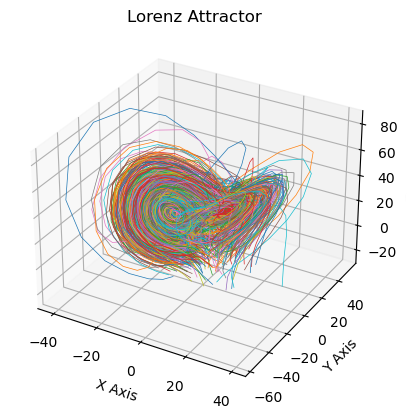

In [16]:
ax = plt.figure().add_subplot(projection='3d')

for i in range(data.shape[0]):
    ax.plot(data[i,:,0],data[i,:,1],data[i,:,2], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")